In [1]:
pip install --upgrade scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 76.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install niaarm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
ydata-profiling 4.12.1 requires matplotlib<3.10,>=3.5, but you have matplotlib 3.10.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from niaarm import Dataset, get_rules
from niapy.algorithms.basic import DifferentialEvolution
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import re
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import pearsonr

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from imblearn.under_sampling import NearMiss

from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from xgboost import XGBClassifier

In [4]:
# pima dataset
df = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')

#health indicatorts dataset
file3 = pd.read_csv('/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_health_indicators_BRFSS2015.csv')
file2 = pd.read_csv("/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
file1 = pd.read_csv('/kaggle/input/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv')

In [5]:
# Adding a source column to identify the data source
file1['Source'] = 'file1'
file2['Source'] = 'file2'
file3['Source'] = 'file3'

# Converting the target variable to binary classification (0 and 1)
file1['Diabetes_binary'] = file1['Diabetes_012'].apply(lambda x: 1 if x >= 1 else 0)
file2['Diabetes_binary'] = file2['Diabetes_binary']  # Already binary
file3['Diabetes_binary'] = file3['Diabetes_binary']  # Already binary

In [6]:
# Dropping the original target variable in file1 after conversion
file1 = file1.drop(columns=['Diabetes_012'])

In [7]:
# Merging all files into a single dataset
data = pd.concat([file1, file2, file3], ignore_index=True)

In [8]:
df.sample()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
249,1,111,86,19,0,30.1,0.143,23,0


In [9]:
data.sample()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Source,Diabetes_binary
471581,0.0,0.0,1.0,21.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0,file3,0.0


In [10]:
# Dropping the 'Source' column
columns_to_drop = ['Source']
data = data.drop(columns=columns_to_drop)

In [11]:
df.shape

(768, 9)

In [12]:
data.shape

(578052, 22)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578052 entries, 0 to 578051
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HighBP                578052 non-null  float64
 1   HighChol              578052 non-null  float64
 2   CholCheck             578052 non-null  float64
 3   BMI                   578052 non-null  float64
 4   Smoker                578052 non-null  float64
 5   Stroke                578052 non-null  float64
 6   HeartDiseaseorAttack  578052 non-null  float64
 7   PhysActivity          578052 non-null  float64
 8   Fruits                578052 non-null  float64
 9   Veggies               578052 non-null  float64
 10  HvyAlcoholConsump     578052 non-null  float64
 11  AnyHealthcare         578052 non-null  float64
 12  NoDocbcCost           578052 non-null  float64
 13  GenHlth               578052 non-null  float64
 14  MentHlth              578052 non-null  float64
 15  

In [15]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [16]:
data.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0,0.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0,0.0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0,0.0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0,0.0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0,0.0


In [17]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [18]:
data.describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
count,578052.000000,578052.000000,578052.000000,578052.000000,578052.000000,578052.000000,578052.000000,578052.000000,578052.000000,578052.000000,...,578052.000000,578052.000000,578052.000000,578052.000000,578052.000000,578052.000000,578052.000000,578052.000000,578052.000000,578052.000000
mean,0.445444,0.436544,0.964209,28.562700,0.447095,0.043212,0.100744,0.750000,0.631509,0.808650,...,0.085368,2.551222,3.254145,4.433878,0.178558,0.442379,8.099617,5.034599,6.010392,0.191452
std,0.497015,0.495957,0.185769,6.689993,0.497194,0.203335,0.300989,0.433013,0.482396,0.393364,...,0.279428,1.079378,7.509915,8.908079,0.382982,0.496669,3.035618,0.992077,2.087400,0.393444
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,0.750000,0.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000,0.000000
50%,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000,0.000000
75%,1.000000,1.000000,1.000000,32.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000,0.000000
max,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000,1.000000


EDA

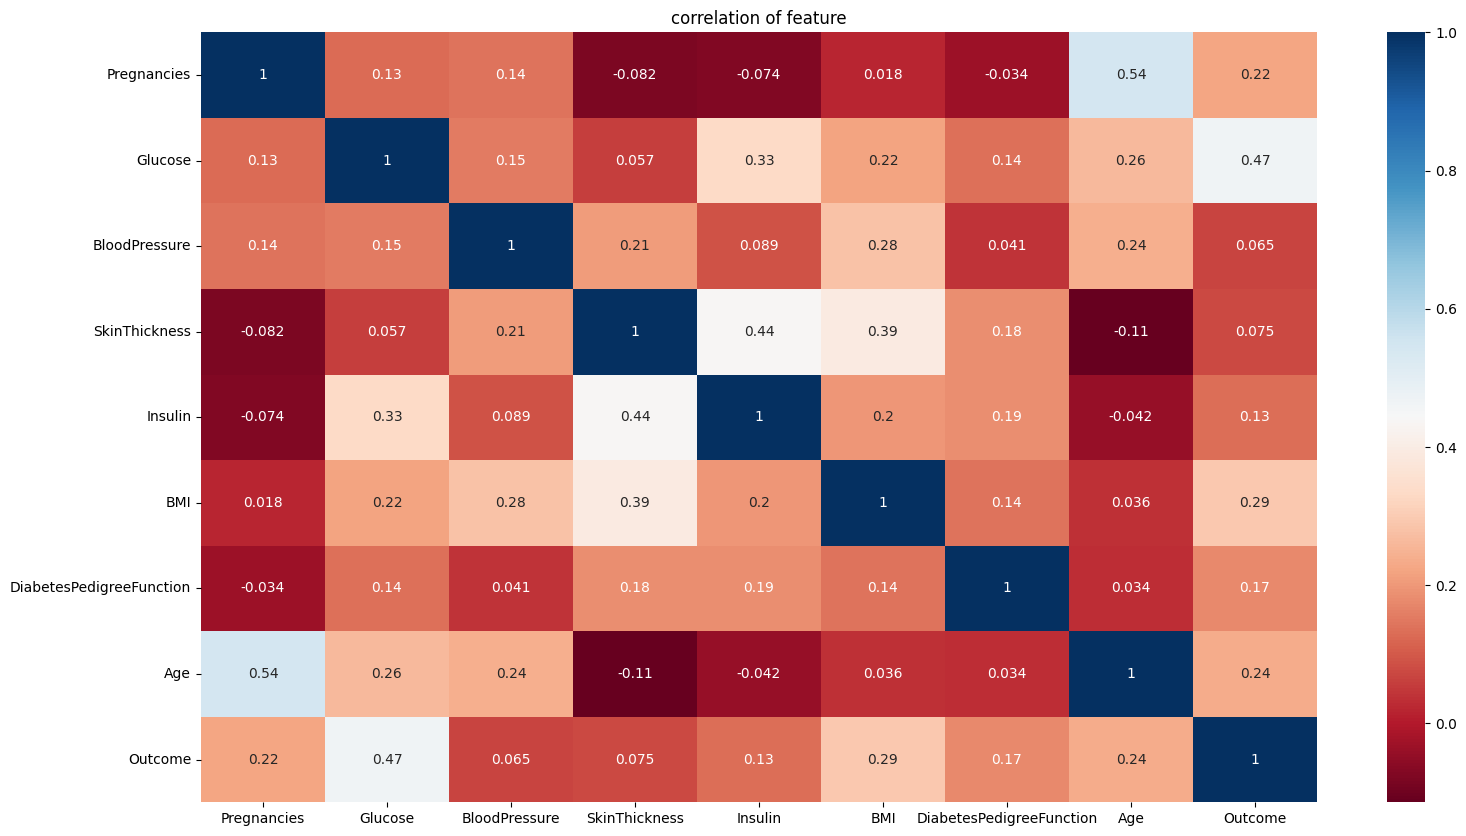

In [19]:
plt.figure(figsize = (18,10))
sns.heatmap(df.corr(),annot=True , cmap ='RdBu' )
plt.title("correlation of feature")
plt.show()

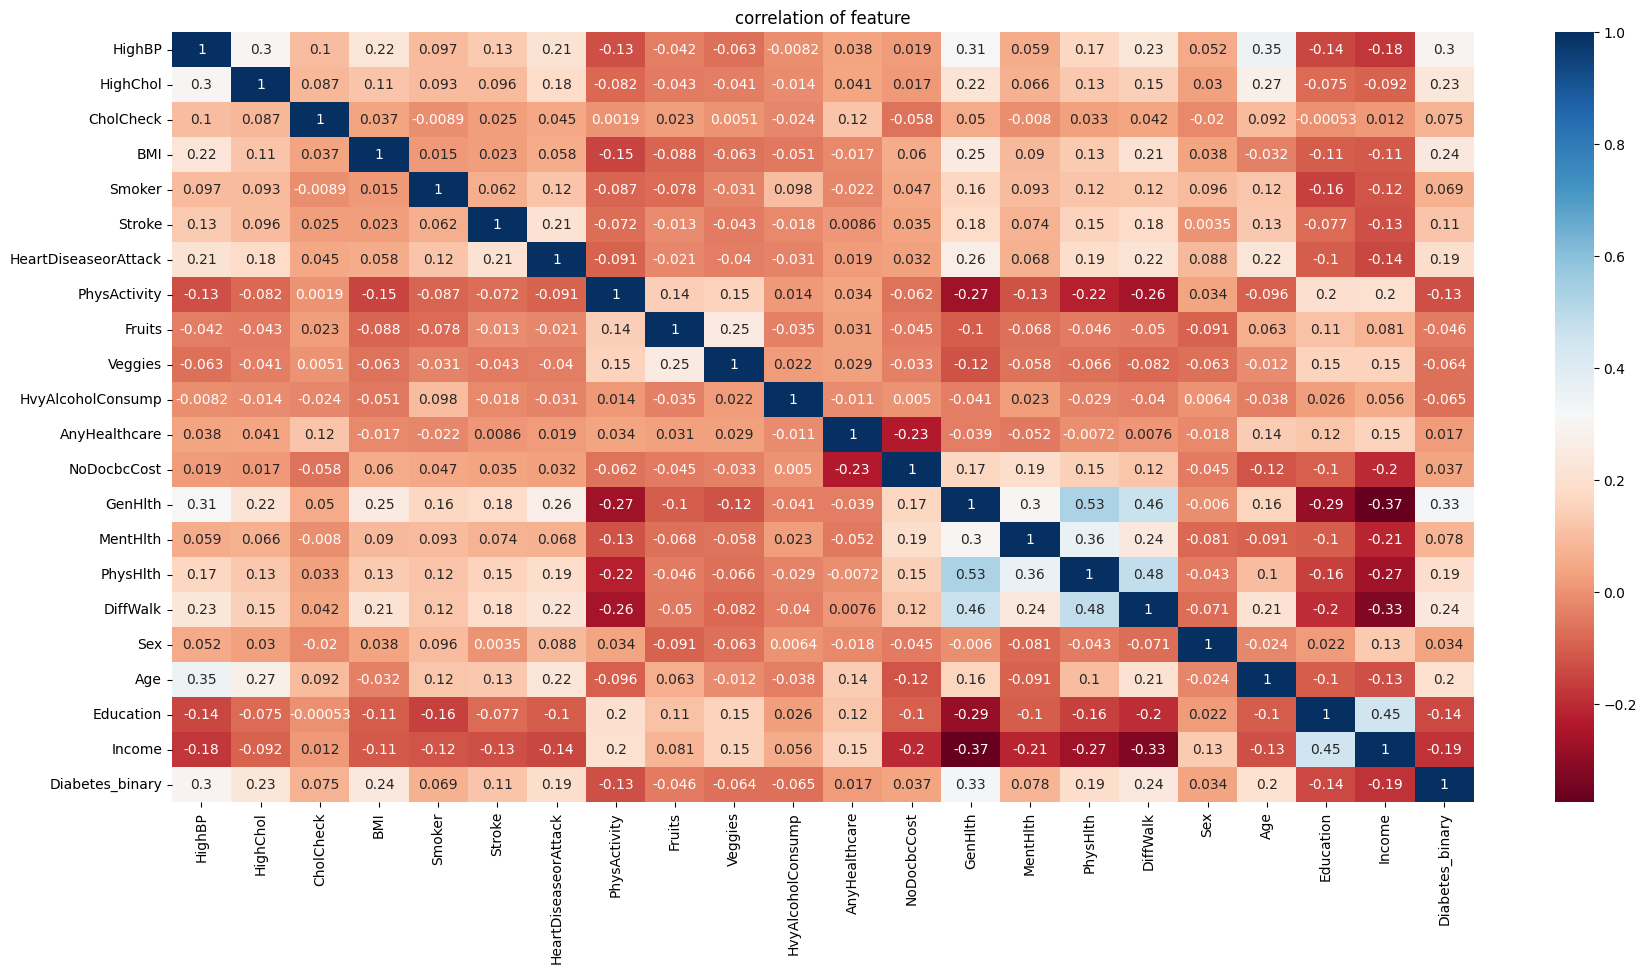

In [20]:
plt.figure(figsize = (21,10))
sns.heatmap(data.corr(),annot=True , cmap ='RdBu' )
plt.title("correlation of feature")
plt.show()

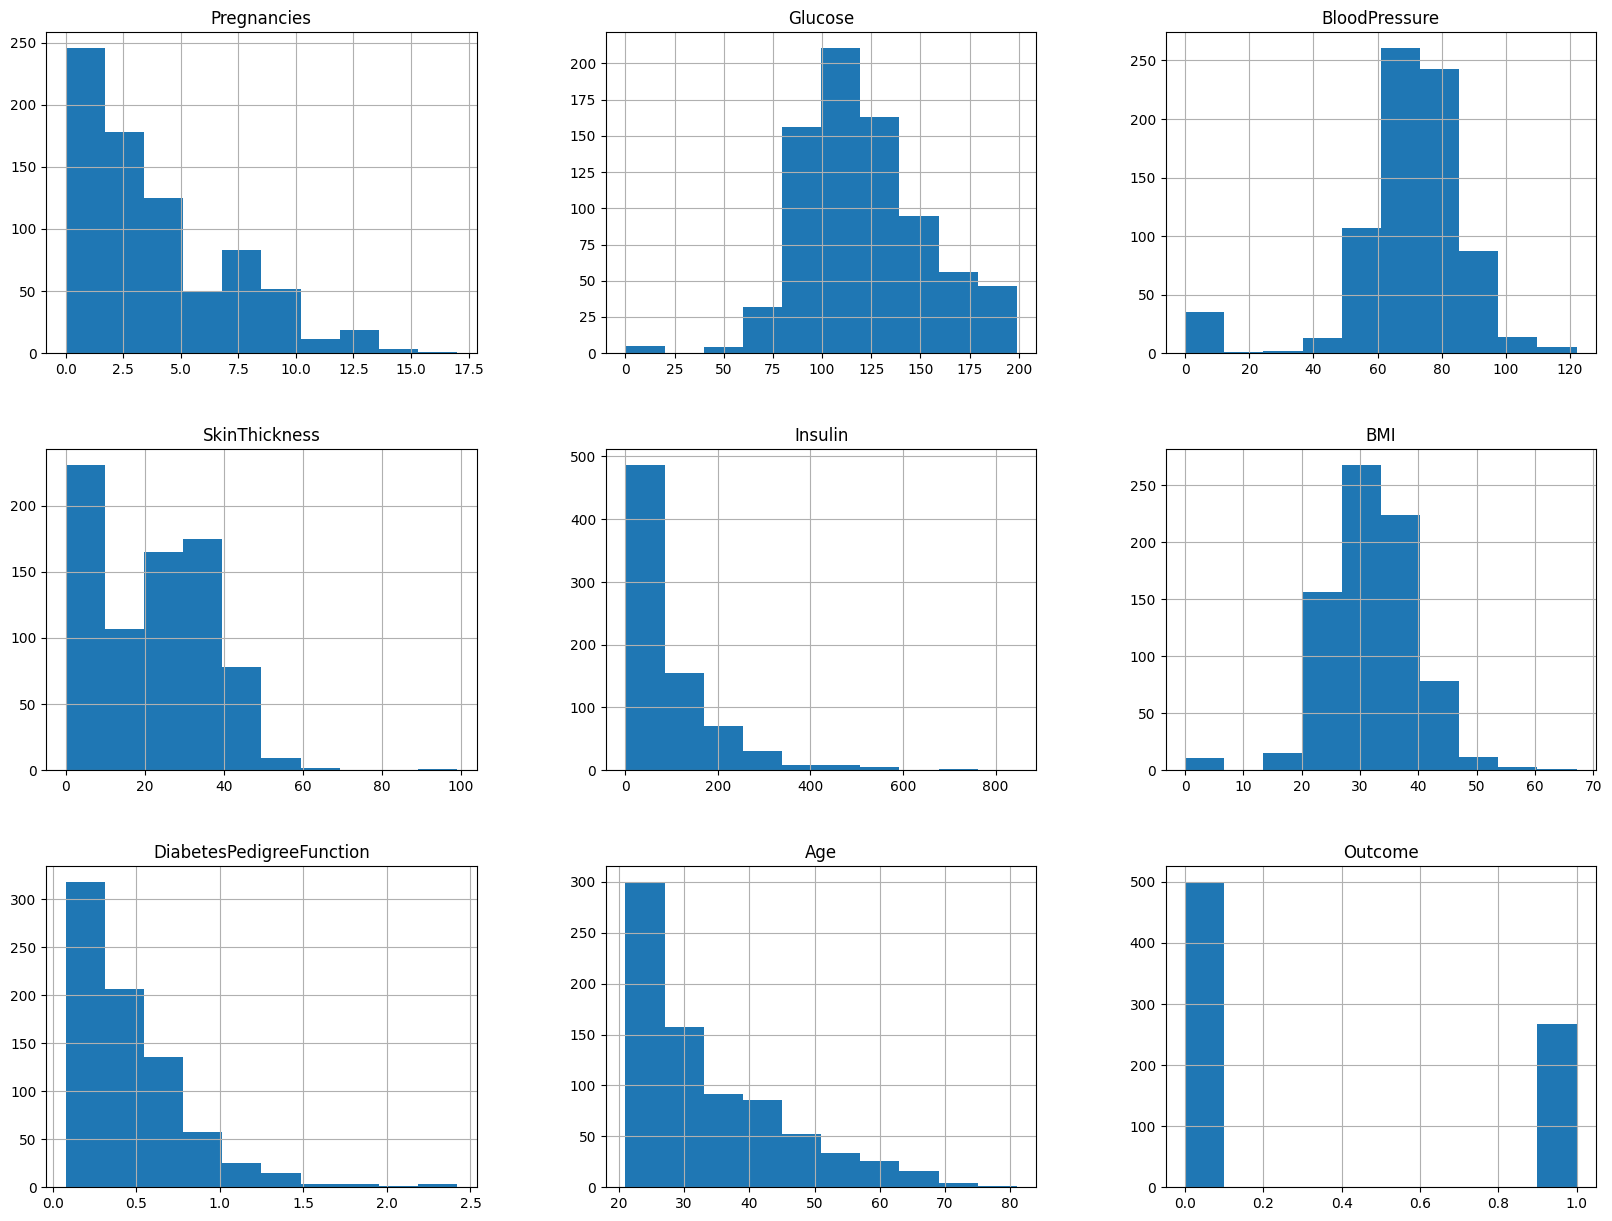

In [21]:
df.hist(figsize=(20,15));

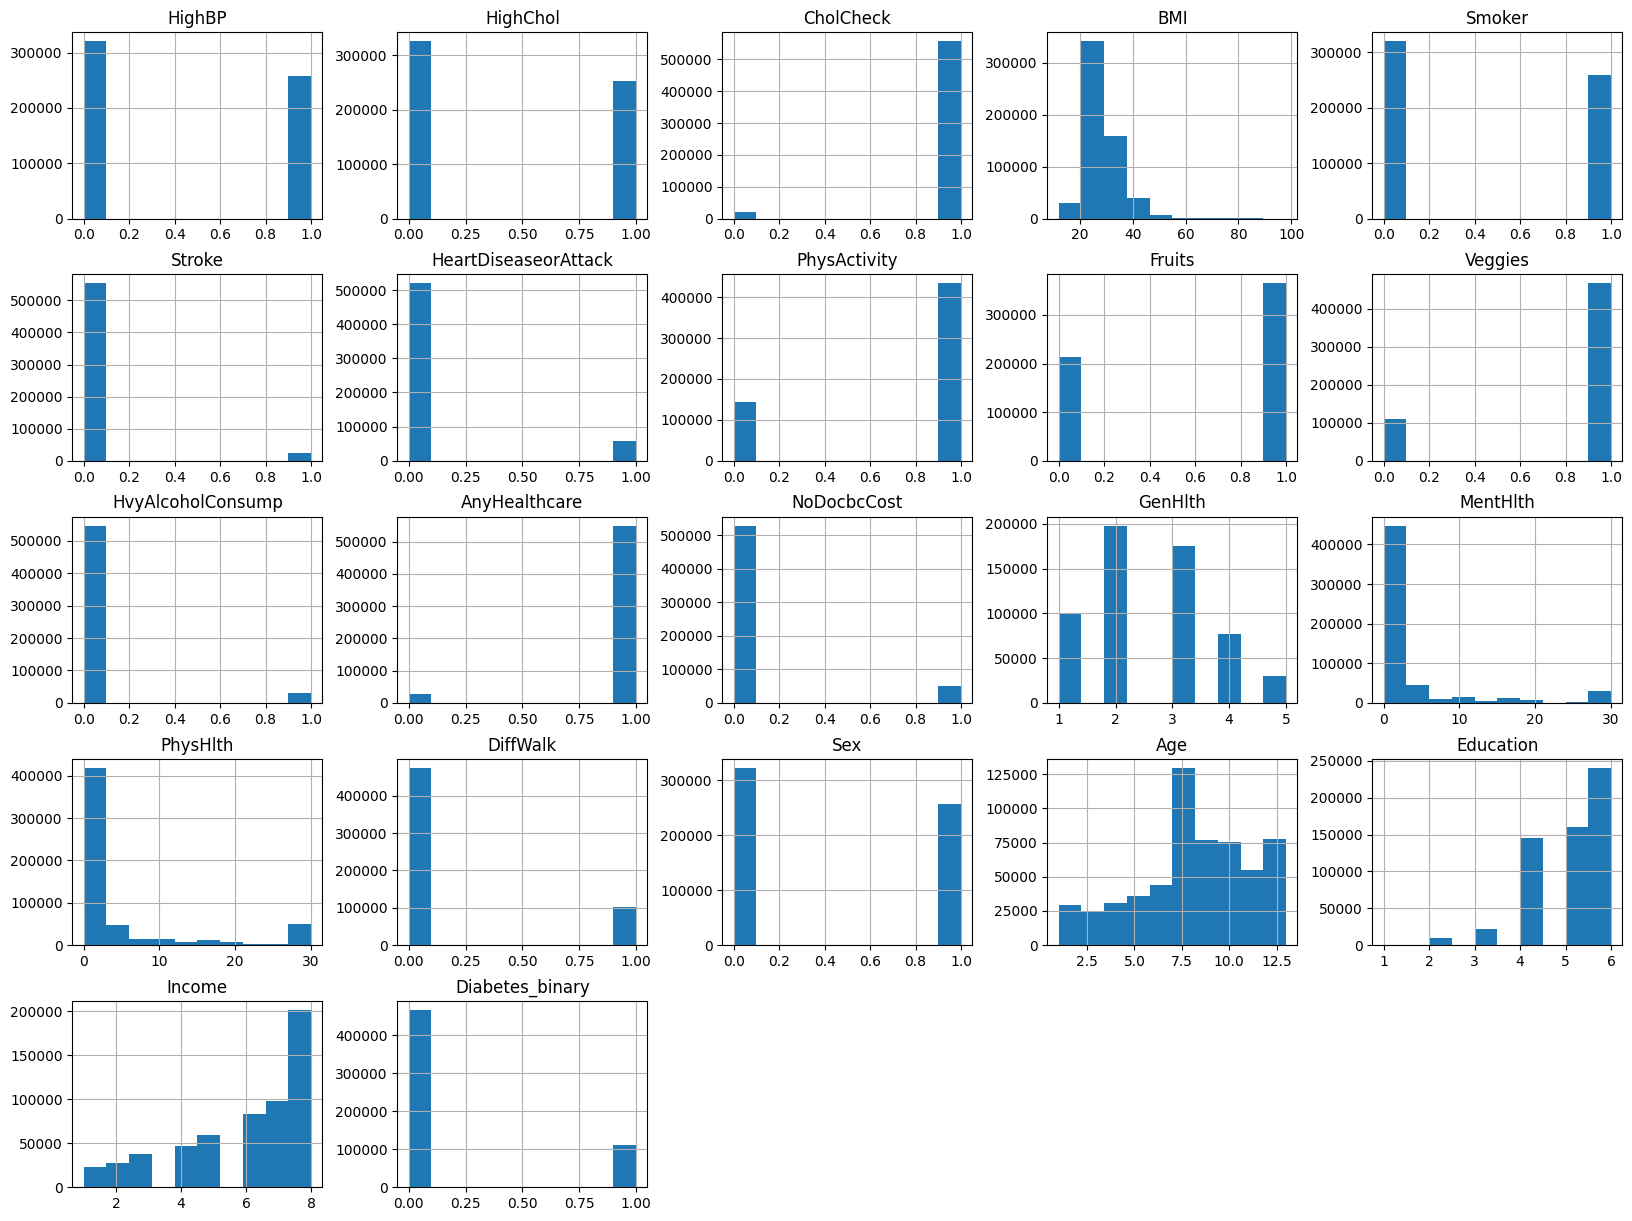

In [22]:
data.hist(figsize=(20,15));

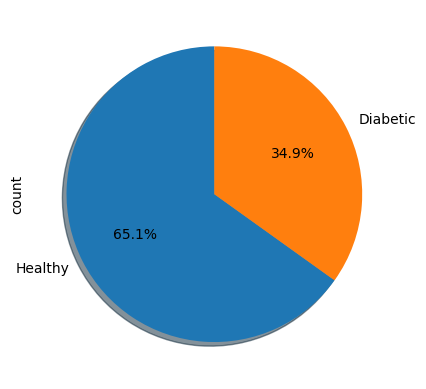

In [23]:
labels = 'Healthy','Diabetic'

df.Outcome.value_counts().plot.pie(labels=labels, autopct='%1.1f%%',shadow=True, startangle=90);

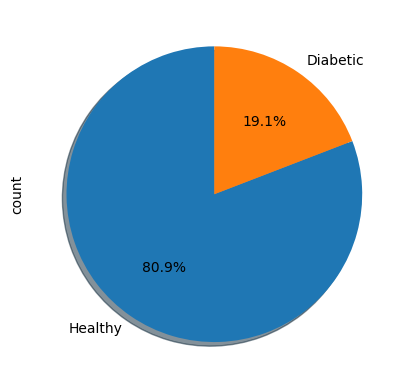

In [24]:
labels = 'Healthy','Diabetic'

data.Diabetes_binary.value_counts().plot.pie(labels=labels, autopct='%1.1f%%',shadow=True, startangle=90);

Preprocessing

Dealing with imbalancing

In [25]:
df_features = data.drop("Diabetes_binary",axis=1)
df_target = data["Diabetes_binary"]

In [26]:
df_target.value_counts()

Diabetes_binary
0.0    467383
1.0    110669
Name: count, dtype: int64

In [27]:
nm = NearMiss(version = 1 , n_neighbors = 10)

df_features, df_target = nm.fit_resample(df_features, df_target)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [28]:
df_features.shape , df_target.shape

((221338, 21), (221338,))

check and drop duplicate data

In [29]:
df.duplicated().sum()

0

In [30]:
data.duplicated().sum()

344018

In [31]:
data.drop_duplicates(inplace = True)

In [32]:
data.duplicated().sum()

0

In [33]:
# Function to preprocess data
def preprocess_data(df):
    # Handle missing values
    df = df.fillna(df.median())

    # Encode categorical variables
    label_encoders = {}
    for column in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

    # Normalize numeric features
    scaler = StandardScaler()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df

# Preprocess Pima Dataset
pima_processed = preprocess_data(df)

# Preprocess Health Dtaset
health_processed = preprocess_data(data)

In [34]:
# Ensure target variable is categorical
def preprocess_target(target):
    if target.dtype in ['float64', 'int64']:
        return target.astype(int)  # Convert to integer if it's a float
    return target

In [35]:
# Separate features and target for each dataset
def split_features_target(df, target_column):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    y = preprocess_target(y)
    return X, y
    
target_column_pima = "Outcome"
target_column_health = "Diabetes_binary"

In [36]:
X_pima, y_pima = split_features_target(pima_processed, target_column_pima)
X_health, y_health = split_features_target(health_processed, target_column_health)

In [37]:
# Split into train and test sets
X_pima_train, X_pima_test, y_pima_train, y_pima_test = train_test_split(X_pima, y_pima, test_size=0.2, random_state=42)
X_health_train, X_health_test, y_health_train, y_health_test = train_test_split(X_health, y_health, test_size=0.2, random_state=42)


Performance Metrics for Pima Indians Diabetes Dataset:
Accuracy: 0.7272727272727273
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79        99
           1       0.62      0.62      0.62        55

    accuracy                           0.73       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154



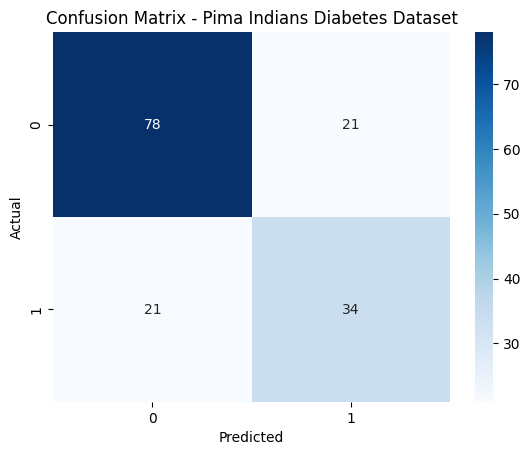


Performance Metrics for Diabetes Health Indicators Dataset:
Accuracy: 0.8132116991048347
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89     38961
           2       0.37      0.17      0.23      7846

    accuracy                           0.81     46807
   macro avg       0.61      0.56      0.56     46807
weighted avg       0.77      0.81      0.78     46807



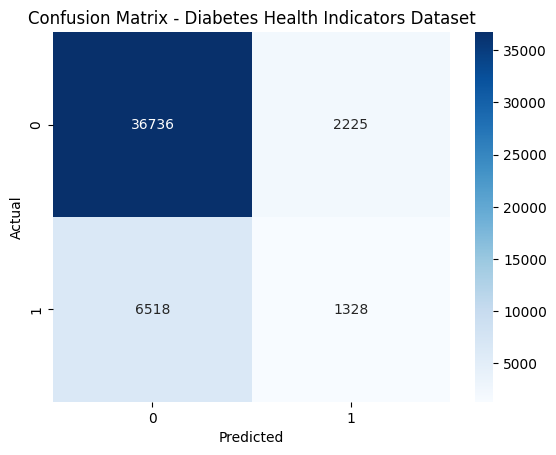

In [38]:
# Function to train and evaluate a model
def train_and_evaluate(X_train, X_test, y_train, y_test, dataset_name):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nPerformance Metrics for {dataset_name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Train and evaluate on Pima Dataset
train_and_evaluate(X_pima_train, X_pima_test, y_pima_train, y_pima_test, "Pima Indians Diabetes Dataset")

# Train and evaluate on Health
train_and_evaluate(X_health_train, X_health_test, y_health_train, y_health_test, "Diabetes Health Indicators Dataset")

In [39]:
from mlxtend.frequent_patterns import apriori, association_rules

In [40]:
# Convert numeric data to categorical for rule mining
def convert_to_categorical(df, bins=3):
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = pd.qcut(df[col], q=bins, duplicates='drop').astype(str)
    return df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
# Prepare data for rule mining
def prepare_data_for_rule_mining(df, target_column):
    # Convert to categorical
    df_categorical = convert_to_categorical(df.copy())
    # Remove target column for rule mining
    df_categorical.drop(columns=[target_column], inplace=True)
    # Convert to one-hot encoded (transactional binary matrix)
    df_encoded = pd.get_dummies(df_categorical)
    return df_encoded

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# Perform rule mining
def perform_rule_mining(df_encoded, min_support=0.05, metric="lift", min_threshold=1.0):
    # Generate frequent itemsets
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    print("\nFrequent Itemsets:")
    print(frequent_itemsets)

    # Generate association rules
    rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)
    print("\nAssociation Rules:")
    print(rules)

    return rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
# Apply rule mining to Pima dataset
print("\nRule Mining for Pima Indians Diabetes Dataset:")
df_encoded_pima = prepare_data_for_rule_mining(pima_processed, target_column_pima)
rules_pima = perform_rule_mining(df_encoded_pima)

# Apply rule mining to Health dataset
#print("\nRule Mining for Diabetes Health Indicators Dataset:")
#df_encoded_health = prepare_data_for_rule_mining(health_processed, target_column_health)
#rules_health = perform_rule_mining(df_encoded_health)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Rule Mining for Pima Indians Diabetes Dataset:

Frequent Itemsets:
      support                                           itemsets
0    0.260417                      (Pregnancies_(-0.548, 0.343])
1    0.454427        (Pregnancies_(-1.1429999999999998, -0.548])
2    0.285156                       (Pregnancies_(0.343, 3.907])
3    0.329427                          (Glucose_(-0.497, 0.285])
4    0.343750            (Glucose_(-3.7849999999999997, -0.497])
..        ...                                                ...
699  0.063802  (SkinThickness_(-0.473, 0.594], Glucose_(-3.78...
700  0.066406  (Glucose_(-3.7849999999999997, -0.497], Age_(-...
701  0.058594  (Age_(-1.043, -0.701], Pregnancies_(-1.1429999...
702  0.052083  (SkinThickness_(-0.473, 0.594], Age_(-1.043, -...
703  0.058594  (Glucose_(-3.7849999999999997, -0.497], Age_(-...

[704 rows x 2 columns]

Association Rules:
                                  antecedents  \
0               (Pregnancies_(-0.548, 0.343])   
1         

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated an

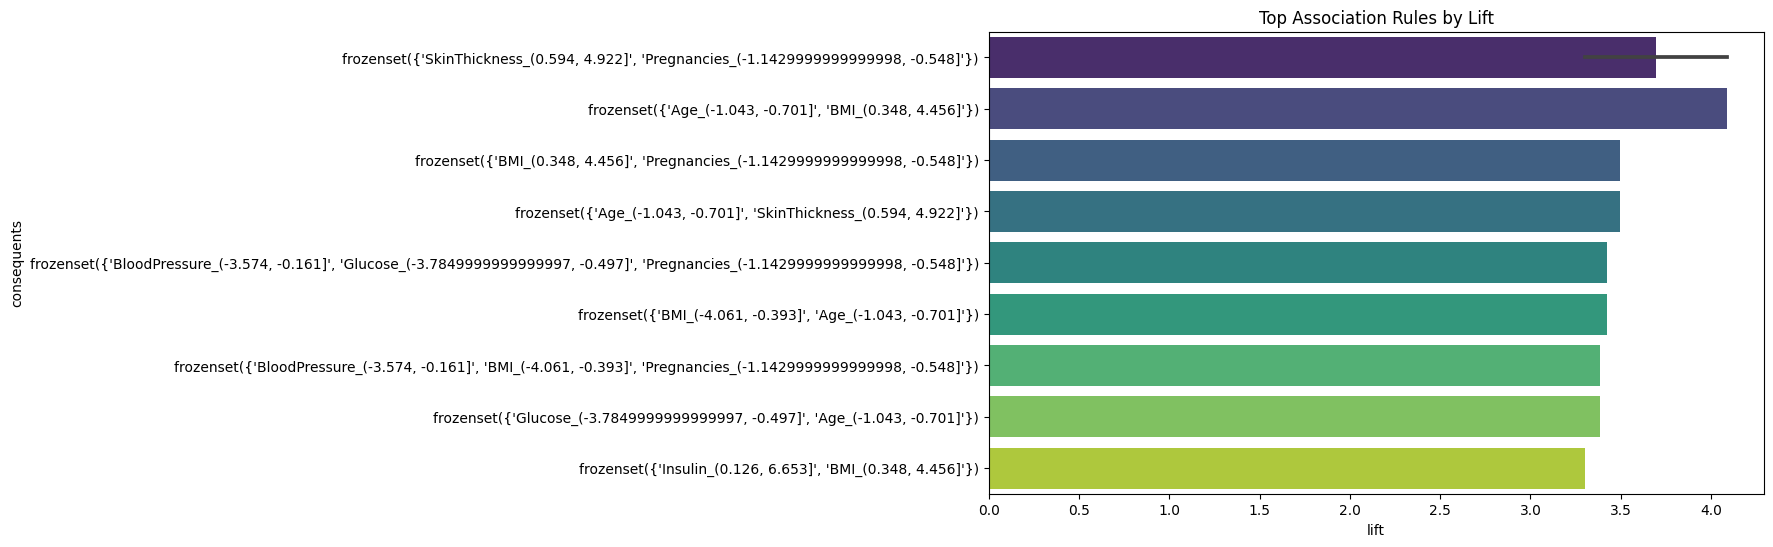

In [44]:
# Visualization of top rules (optional)
def visualize_rules(rules, top_n=10):
    plt.figure(figsize=(10, 6))
    sorted_rules = rules.sort_values(by="lift", ascending=False).head(top_n)
    sns.barplot(x="lift", y="consequents", data=sorted_rules, palette="viridis")
    plt.title("Top Association Rules by Lift")
    plt.show()

# Visualize top rules for Pima dataset
visualize_rules(rules_pima)

# Visualize top rules mining to Health dataset
#visualize_rules(rules_health)

In [45]:
pip install efficient-apriori

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Note: you may need to restart the kernel to use updated packages.


In [46]:
transactions_pima = []
for index, row in pima_processed.iterrows():
    transaction = tuple(row.index[row == 1])
    transactions_pima.append(transaction)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
min_support = 0.01  # Start with a low value and adjust as needed
min_confidence = 0.5  # Adjust based on desired rule strength

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
threshold = 0.5  # Define an appropriate threshold based on domain knowledge
pima_binarized = pima_processed.applymap(lambda x:1 if x > threshold else 0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-48-03048ed3fb19>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pima_binarized = pima_processed.applymap(lambda x:1 if x > threshold else 0)


In [49]:
from mlxtend.frequent_patterns import fpgrowth

# Apply FP-Growth algorithm
frequent_itemsets_pima = fpgrowth(pima_binarized, min_support=0.01, use_colnames=True)

# Generate association rules
from mlxtend.frequent_patterns import association_rules
rules_pima = association_rules(frequent_itemsets_pima, metric="confidence", min_threshold=0.5)

# Display rules
print(rules_pima)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                          antecedents      consequents  \
0                                       (Pregnancies)        (Outcome)   
1                        (SkinThickness, Pregnancies)        (Outcome)   
2                                           (Glucose)        (Outcome)   
3                                           (Outcome)        (Glucose)   
4                            (Glucose, SkinThickness)        (Outcome)   
..                                                ...              ...   
908               (SkinThickness, Age, BloodPressure)        (Glucose)   
909            (Glucose, Age, Outcome, SkinThickness)  (BloodPressure)   
910  (Glucose, Outcome, BloodPressure, SkinThickness)            (Age)   
911      (Glucose, Age, BloodPressure, SkinThickness)        (Outcome)   
912      (SkinThickness, Age, Outcome, BloodPressure)        (Glucose)   

     antecedent support  consequent support   support  confidence      lift  \
0              0.285156         

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical

                                           antecedents  \
253     (Outcome, Insulin, Pregnancies, BloodPressure)   
345         (BMI, Insulin, Pregnancies, BloodPressure)   
251     (Glucose, Insulin, Pregnancies, BloodPressure)   
269       (SkinThickness, Age, Insulin, BloodPressure)   
346                 (Age, Insulin, BMI, BloodPressure)   
136  (SkinThickness, Age, BloodPressure, DiabetesPe...   
252             (Glucose, Age, Insulin, BloodPressure)   
338       (SkinThickness, Age, Insulin, BloodPressure)   
267  (SkinThickness, Insulin, Pregnancies, BloodPre...   
47                  (Glucose, Age, BMI, SkinThickness)   

                consequents  antecedent support  consequent support   support  \
253          (Glucose, Age)            0.019531            0.113281  0.014323   
345          (Age, Outcome)            0.011719            0.140625  0.010417   
251          (Age, Outcome)            0.016927            0.140625  0.014323   
269  (Outcome, Pregnancies)          

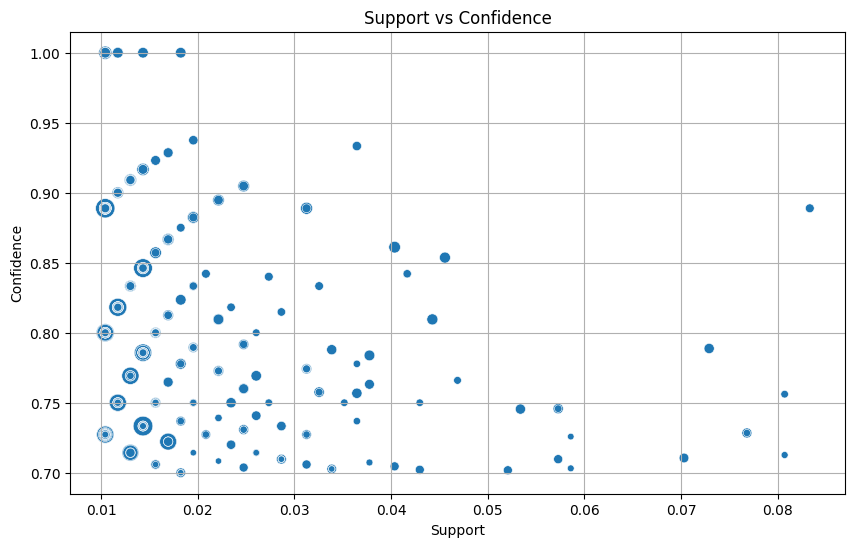

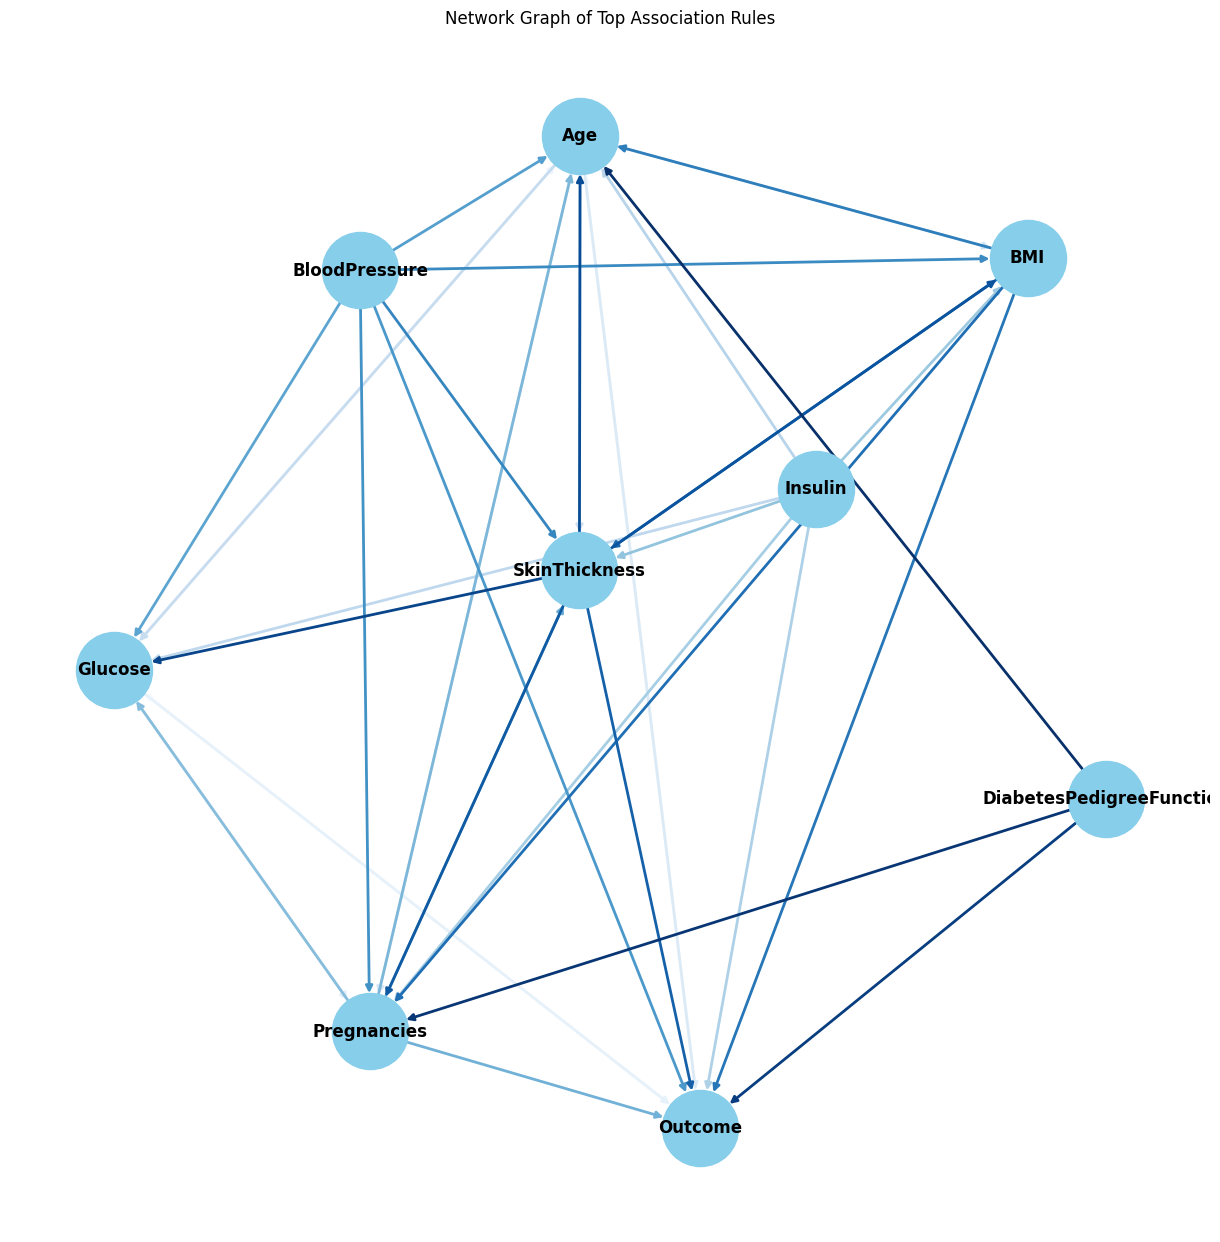

In [50]:
# Apply FP-Growth algorithm
frequent_itemsets_pima = fpgrowth(pima_binarized, min_support=0.01, use_colnames=True)

# Generate association rules
rules_pima = association_rules(frequent_itemsets_pima, metric="confidence", min_threshold=0.6)

# Filter rules based on lift and confidence
filtered_rules_pima = rules_pima[(rules_pima['lift'] > 1) & (rules_pima['confidence'] > 0.7)]

# Sort rules by lift
sorted_rules_pima = filtered_rules_pima.sort_values(by='lift', ascending=False)

# Display top 10 rules
print(sorted_rules_pima.head(10))

# Visualization: Scatter plot of Support vs Confidence
plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', size='lift', data=sorted_rules_pima, legend=False, sizes=(20, 200))
plt.title('Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

# Visualization: Network Graph
import networkx as nx

def draw_graph(rules, top_n):
    G = nx.DiGraph()

    top_rules = rules.head(top_n)
    for _, rule in top_rules.iterrows():
        for antecedent in rule['antecedents']:
            for consequent in rule['consequents']:
                G.add_edge(antecedent, consequent, weight=rule['lift'])

    pos = nx.spring_layout(G, k=1.5, iterations=50)
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', edge_color=range(len(G.edges)), edge_cmap=plt.cm.Blues, width=2.0)
    plt.title('Network Graph of Top Association Rules')
    plt.show()

# Draw network graph for top 20 rules
draw_graph(sorted_rules_pima, top_n=20)


In [51]:
transactions = []
for index, row in health_processed.iterrows():
    transaction = tuple(row.index[row == 1])
    transactions.append(transaction)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
min_support = 0.01  # Start with a low value and adjust as needed
min_confidence = 0.5  # Adjust based on desired rule strength

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
threshold = 0.5  # Define an appropriate threshold based on domain knowledge
health_binarized = health_processed.applymap(lambda x: 1 if x > threshold else 0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-53-4c794ba5382e>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  health_binarized = health_processed.applymap(lambda x: 1 if x > threshold else 0)


In [54]:
from mlxtend.frequent_patterns import fpgrowth

# Apply FP-Growth algorithm
frequent_itemsets = fpgrowth(health_binarized, min_support=0.01, use_colnames=True)

# Generate association rules
from mlxtend.frequent_patterns import association_rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Display rules
print(rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                                             antecedents  \
0                                               (Smoker)   
1                                               (Smoker)   
2                                               (Smoker)   
3                                 (PhysActivity, Smoker)   
4                                      (Smoker, Veggies)   
...                                                  ...   
24951  (PhysActivity, Income, Smoker, HvyAlcoholConsump)   
24952        (Income, Smoker, Fruits, HvyAlcoholConsump)   
24953       (HvyAlcoholConsump, Smoker, Fruits, Veggies)   
24954       (HvyAlcoholConsump, Income, Fruits, Veggies)   
24955       (HvyAlcoholConsump, Income, Smoker, Veggies)   

                   consequents  antecedent support  consequent support  \
0                    (Veggies)            0.466360            0.794026   
1               (PhysActivity)            0.466360            0.731889   
2                     (Fruits)            0.466360       

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                                             antecedents          consequents  \
5609      (Diabetes_binary, MentHlth, DiffWalk, GenHlth)   (PhysHlth, HighBP)   
5637     (Diabetes_binary, DiffWalk, HighChol, MentHlth)  (PhysHlth, GenHlth)   
5610       (Diabetes_binary, HighBP, DiffWalk, MentHlth)  (PhysHlth, GenHlth)   
5595               (Diabetes_binary, DiffWalk, MentHlth)  (PhysHlth, GenHlth)   
5133      (HighChol, DiffWalk, Smoker, HighBP, MentHlth)  (PhysHlth, GenHlth)   
12327  (HeartDiseaseorAttack, HighChol, PhysHlth, Dif...    (HighBP, GenHlth)   
12190  (PhysHlth, HeartDiseaseorAttack, DiffWalk, Hig...    (HighBP, GenHlth)   
12243  (HeartDiseaseorAttack, HighChol, PhysHlth, Dif...    (HighBP, GenHlth)   
12731  (PhysHlth, HeartDiseaseorAttack, Diabetes_binary)    (HighBP, GenHlth)   
5606     (PhysHlth, Diabetes_binary, DiffWalk, MentHlth)    (HighBP, GenHlth)   

       antecedent support  consequent support   support  confidence      lift  \
5609             0.015459  

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


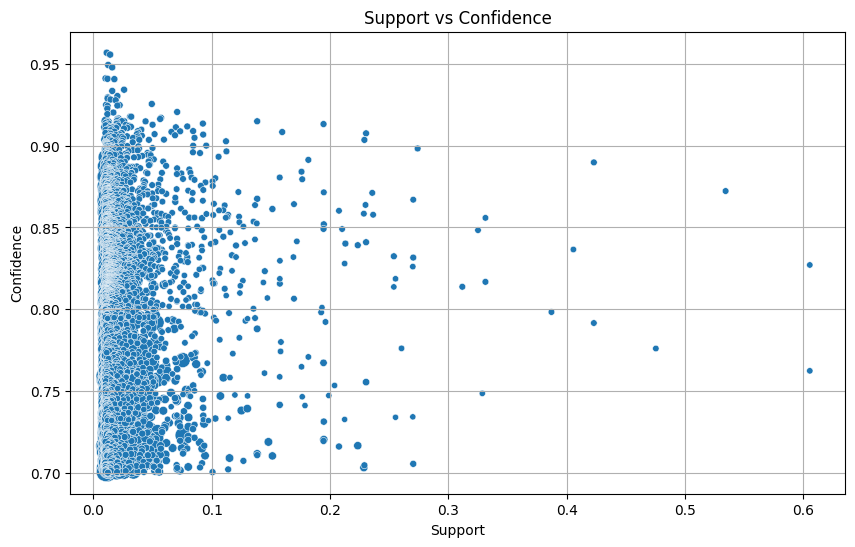

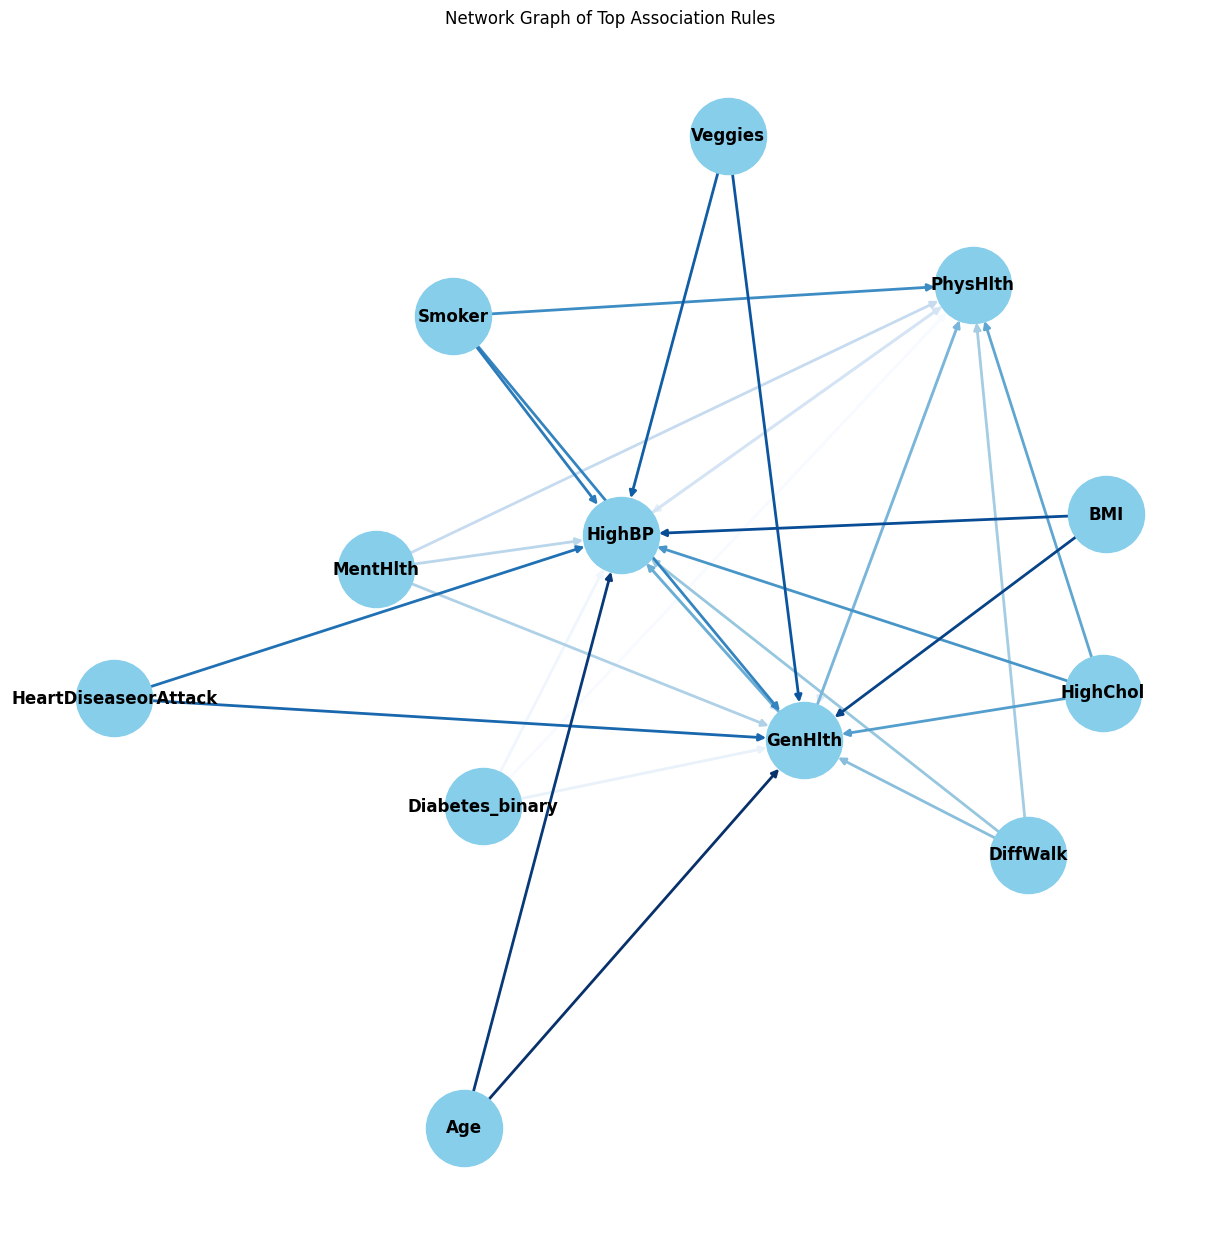

In [55]:
# Apply FP-Growth algorithm
frequent_itemsets = fpgrowth(health_binarized, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Filter rules based on lift and confidence
filtered_rules = rules[(rules['lift'] > 1) & (rules['confidence'] > 0.7)]

# Sort rules by lift
sorted_rules = filtered_rules.sort_values(by='lift', ascending=False)

# Display top 10 rules
print(sorted_rules.head(10))

# Visualization: Scatter plot of Support vs Confidence
plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', size='lift', data=sorted_rules, legend=False, sizes=(20, 200))
plt.title('Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

# Visualization: Network Graph
import networkx as nx

def draw_graph(rules, top_n):
    G = nx.DiGraph()

    top_rules = rules.head(top_n)
    for _, rule in top_rules.iterrows():
        for antecedent in rule['antecedents']:
            for consequent in rule['consequents']:
                G.add_edge(antecedent, consequent, weight=rule['lift'])

    pos = nx.spring_layout(G, k=1.5, iterations=50)
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', edge_color=range(len(G.edges)), edge_cmap=plt.cm.Blues, width=2.0)
    plt.title('Network Graph of Top Association Rules')
    plt.show()

# Draw network graph for top 20 rules
draw_graph(sorted_rules, top_n=20)


<h1>Eclat</h1>apriori

In [56]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

# Convert DataFrame to a list of lists for transaction encoding
transactions = health_binarized.apply(lambda row: row.index[row == 1].tolist(), axis=1).tolist()

# Initialize the TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
health_encoded = pd.DataFrame(te_ary, columns=te.columns_)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
print(health_encoded)

          Age    BMI  Diabetes_binary  DiffWalk  Education  Fruits  GenHlth  \
0       False   True            False      True      False   False     True   
1       False  False            False     False       True   False    False   
2       False  False            False      True      False    True     True   
3        True  False            False     False      False    True    False   
4        True  False            False     False      False    True    False   
...       ...    ...              ...       ...        ...     ...      ...   
234029   True  False            False     False      False    True     True   
234030  False   True            False     False      False    True    False   
234031  False  False            False     False       True   False    False   
234032  False  False            False     False       True   False    False   
234033  False  False            False     False      False    True    False   

        HeartDiseaseorAttack  HighBP  HighChol  Hvy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
from collections import defaultdict
from itertools import combinations

def eclat(df, min_support=0.01):
    # Create a dictionary to hold the itemsets and their transaction IDs
    itemsets = defaultdict(set)
    for idx, transaction in df.iterrows():
        for item in df.columns[transaction]:
            itemsets[frozenset([item])].add(idx)

    # Filter itemsets by minimum support
    itemsets = {item: tids for item, tids in itemsets.items() if len(tids) / len(df) >= min_support}

    # Recursive function to find frequent itemsets
    def recursive_eclat(prefix, itemsets):
        frequent_itemsets = {}
        for item, tids in itemsets.items():
            new_itemset = prefix | item
            frequent_itemsets[new_itemset] = tids
            # Generate new combinations
            new_itemsets = {item2: tids2 & tids for item2, tids2 in itemsets.items() if item2 > item}
            # Recursive call
            frequent_itemsets.update(recursive_eclat(new_itemset, new_itemsets))
        return frequent_itemsets

    # Start the recursive process
    return recursive_eclat(frozenset(), itemsets)

# Apply the ECLAT algorithm
frequent_itemsets = eclat(health_encoded, min_support=0.01)

# Convert the results to a DataFrame
results = [{'itemsets': list(itemset), 'support': len(tids) / len(health_encoded)} for itemset, tids in frequent_itemsets.items()]
health_results = pd.DataFrame(results)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
print(health_results)

                  itemsets   support
0                    [BMI]  0.219041
1               [DiffWalk]  0.187618
2                [GenHlth]  0.192271
3                 [HighBP]  0.457737
4               [HighChol]  0.445123
5               [MentHlth]  0.140698
6               [PhysHlth]  0.175522
7                 [Smoker]  0.466360
8                [Veggies]  0.794026
9              [Education]  0.383051
10           [NoDocbcCost]  0.093670
11          [PhysActivity]  0.731889
12                [Fruits]  0.612415
13                [Income]  0.484810
14                   [Age]  0.364943
15                   [Sex]  0.438966
16       [Diabetes_binary]  0.169450
17  [HeartDiseaseorAttack]  0.104130
18                [Stroke]  0.045070
19     [HvyAlcoholConsump]  0.060495


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
#from itertools import combinations

#def generate_rules(frequent_itemsets, min_confidence=0.5):
#    rules = []
#    for itemset in frequent_itemsets:
#        if len(itemset) > 1:
#            for i in range(1, len(itemset)):
#                for antecedent in combinations(itemset, i):
#                    antecedent = frozenset(antecedent)
#                    consequent = itemset - antecedent
#                    antecedent_support = frequent_itemsets[antecedent]
#                    itemset_support = frequent_itemsets[itemset]
#                    confidence = itemset_support / antecedent_support
#                    if confidence >= min_confidence:
#                       rules.append({
#                            'antecedent': list(antecedent),
#                            'consequent': list(consequent),
#                            'support': itemset_support,
#                            'confidence': confidence
#                        })
#    return pd.DataFrame(rules)


# Generate association rules
#health_rules = generate_rules(health_results,min_confidence=0.5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
#print(health_rules)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
#plt.scatter(health_rules['support'], health_rules['confidence'], alpha=0.5)
#plt.xlabel('Support')
#plt.ylabel('Confidence')
#plt.title('Support vs Confidence')
#plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical

                                           antecedents  \
432     (Outcome, Insulin, Pregnancies, BloodPressure)   
501         (BMI, Insulin, Pregnancies, BloodPressure)   
430     (Glucose, Insulin, Pregnancies, BloodPressure)   
482       (SkinThickness, Age, Insulin, BloodPressure)   
502                 (Age, Insulin, BMI, BloodPressure)   
495  (SkinThickness, Age, BloodPressure, DiabetesPe...   
431             (Glucose, Age, Insulin, BloodPressure)   
537       (SkinThickness, Age, Insulin, BloodPressure)   
480  (SkinThickness, Insulin, Pregnancies, BloodPre...   
465                 (Glucose, Age, BMI, SkinThickness)   

                consequents  antecedent support  consequent support   support  \
432          (Glucose, Age)            0.019531            0.113281  0.014323   
501          (Age, Outcome)            0.011719            0.140625  0.010417   
430          (Age, Outcome)            0.016927            0.140625  0.014323   
482  (Outcome, Pregnancies)          

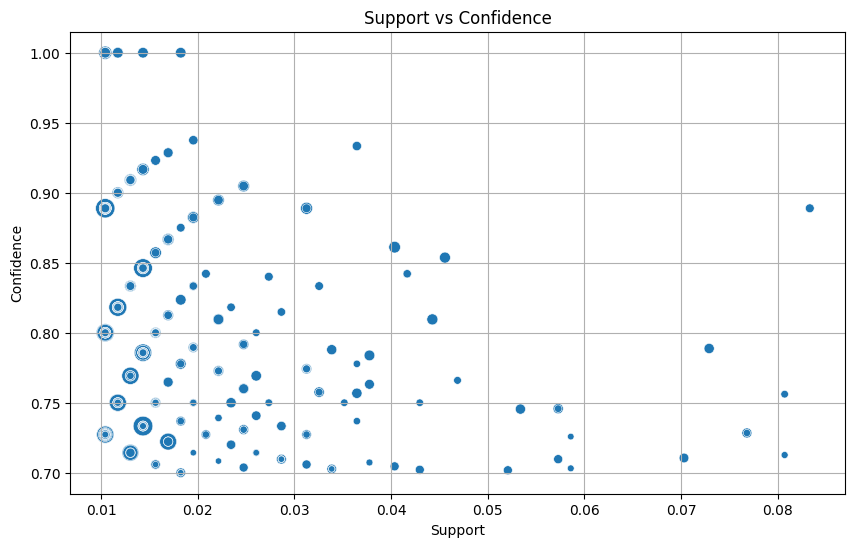

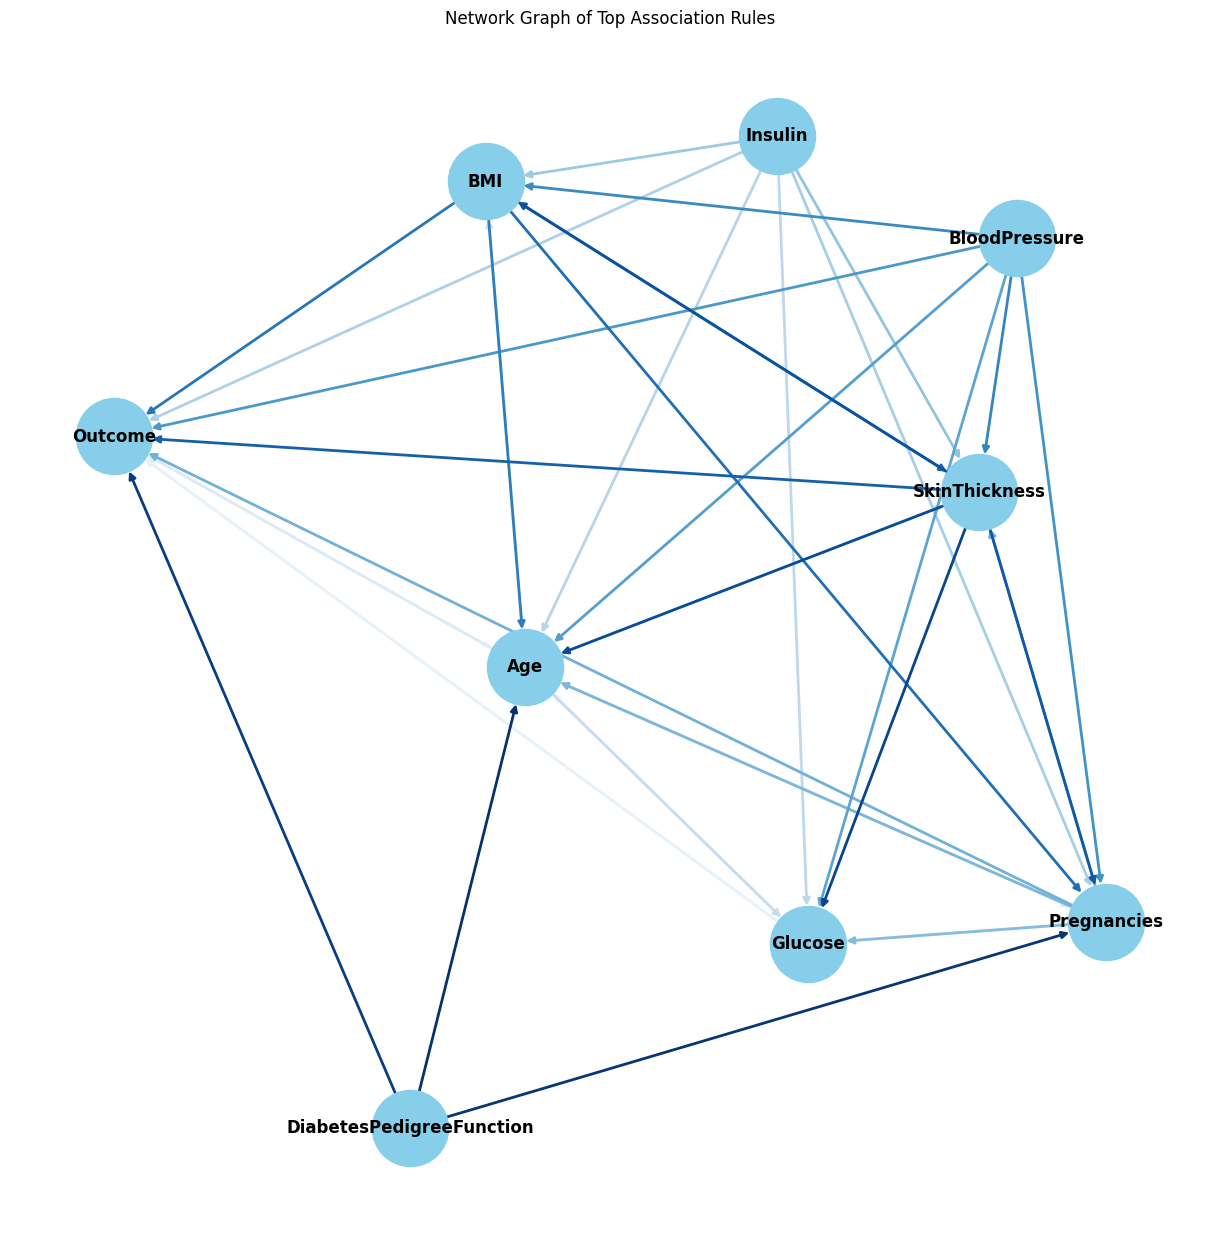

In [63]:
from mlxtend.frequent_patterns import apriori, association_rules

# Apply Apriori algorithm
frequent_itemsets = apriori(pima_binarized, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Filter and sort rules
filtered_rules = rules[(rules['lift'] > 1) & (rules['confidence'] > 0.7)]
sorted_rules = filtered_rules.sort_values(by='lift', ascending=False)

# Display top 10 rules
print(sorted_rules.head(10))

# Visualization: Scatter plot of Support vs Confidence
plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', size='lift', data=sorted_rules, legend=False, sizes=(20, 200))
plt.title('Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

# Visualization: Network Graph
import networkx as nx

def draw_graph(rules, top_n):
    G = nx.DiGraph()
    top_rules = rules.head(top_n)
    for _, rule in top_rules.iterrows():
        for antecedent in rule['antecedents']:
            for consequent in rule['consequents']:
                G.add_edge(antecedent, consequent, weight=rule['lift'])
    pos = nx.spring_layout(G, k=1.5, iterations=50)
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', edge_color=range(len(G.edges)), edge_cmap=plt.cm.Blues, width=2.0)
    plt.title('Network Graph of Top Association Rules')
    plt.show()

# Draw network graph for top 20 rules
draw_graph(sorted_rules, top_n=20)


In [64]:
# from mlxtend.frequent_patterns import apriori, association_rules

# # Apply Apriori algorithm
# frequent_itemsets = apriori(health_binarized, min_support=0.01, use_colnames=True)

# # Generate association rules
# rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# # Filter and sort rules
# filtered_rules = rules[(rules['lift'] > 1) & (rules['confidence'] > 0.7)]
# sorted_rules = filtered_rules.sort_values(by='lift', ascending=False)

# # Display top 10 rules
# print(sorted_rules.head(10))

# # Visualization: Scatter plot of Support vs Confidence
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='support', y='confidence', size='lift', data=sorted_rules, legend=False, sizes=(20, 200))
# plt.title('Support vs Confidence')
# plt.xlabel('Support')
# plt.ylabel('Confidence')
# plt.grid(True)
# plt.show()

# # Visualization: Network Graph
# import networkx as nx

# def draw_graph(rules, top_n):
#     G = nx.DiGraph()
#     top_rules = rules.head(top_n)
#     for _, rule in top_rules.iterrows():
#         for antecedent in rule['antecedents']:
#             for consequent in rule['consequents']:
#                 G.add_edge(antecedent, consequent, weight=rule['lift'])
#     pos = nx.spring_layout(G, k=1.5, iterations=50)
#     plt.figure(figsize=(12, 12))
#     nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', edge_color=range(len(G.edges)), edge_cmap=plt.cm.Blues, width=2.0)
#     plt.title('Network Graph of Top Association Rules')
#     plt.show()

# # Draw network graph for top 20 rules
# draw_graph(sorted_rules, top_n=20)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
# Install PyARMViz if you haven't already
!pip install pyarmviz

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.2/658.2 kB 12.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                                             antecedents          consequents  \
5651      (Diabetes_binary, MentHlth, DiffWalk, GenHlth)   (PhysHlth, HighBP)   
5679     (Diabetes_binary, DiffWalk, HighChol, MentHlth)  (PhysHlth, GenHlth)   
5652       (Diabetes_binary, HighBP, DiffWalk, MentHlth)  (PhysHlth, GenHlth)   
5637               (Diabetes_binary, DiffWalk, MentHlth)  (PhysHlth, GenHlth)   
5175      (HighChol, DiffWalk, Smoker, HighBP, MentHlth)  (PhysHlth, GenHlth)   
12337  (HeartDiseaseorAttack, HighChol, PhysHlth, Dif...    (HighBP, GenHlth)   
12200  (PhysHlth, HeartDiseaseorAttack, DiffWalk, Hig...    (HighBP, GenHlth)   
12253  (HeartDiseaseorAttack, HighChol, PhysHlth, Dif...    (HighBP, GenHlth)   
12741  (PhysHlth, HeartDiseaseorAttack, Diabetes_binary)    (HighBP, GenHlth)   
5648     (PhysHlth, Diabetes_binary, DiffWalk, MentHlth)    (HighBP, GenHlth)   

       antecedent support  consequent support   support  confidence      lift  \
5651             0.015459  

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


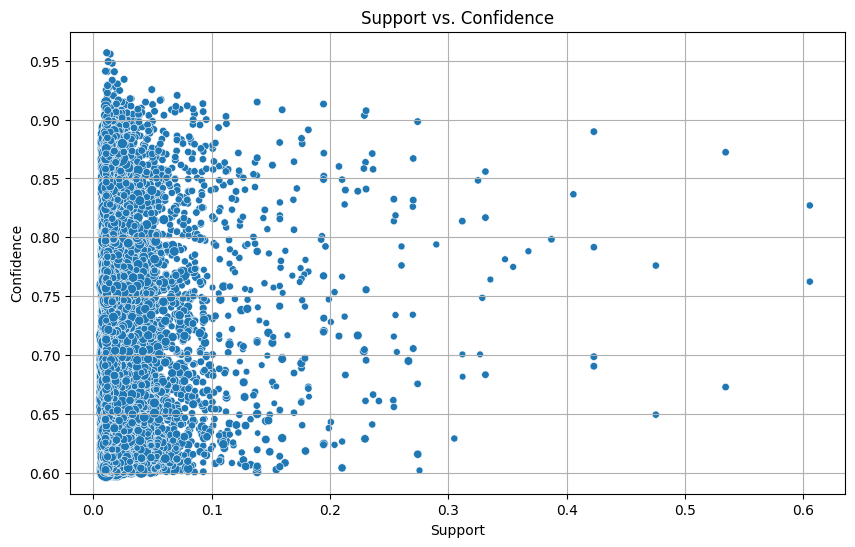

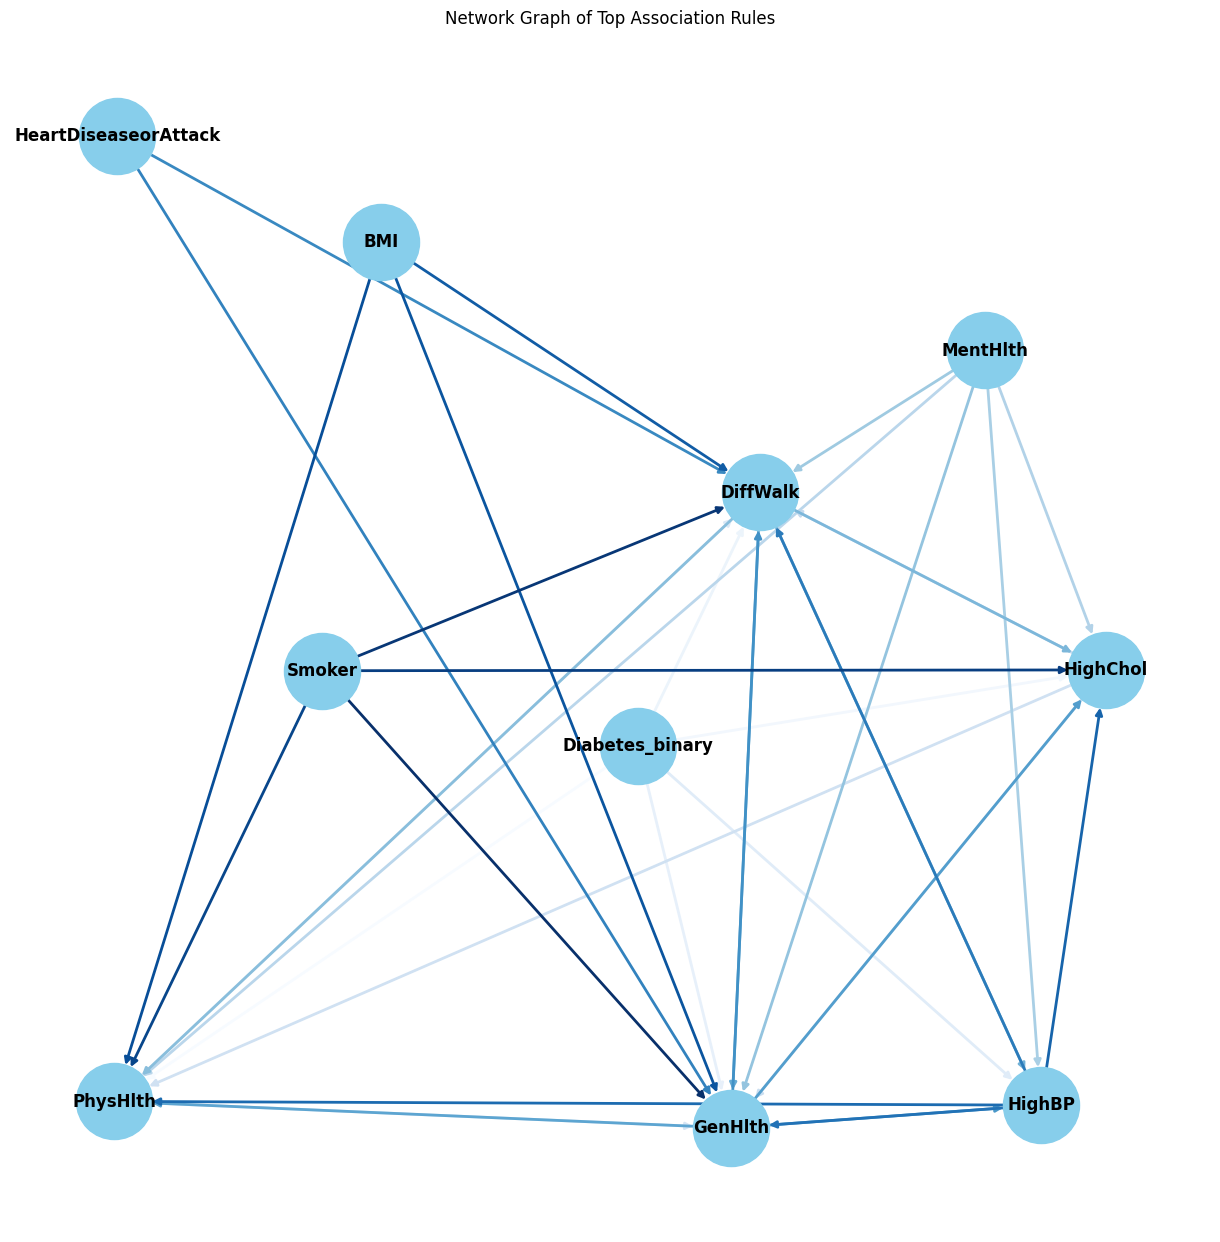

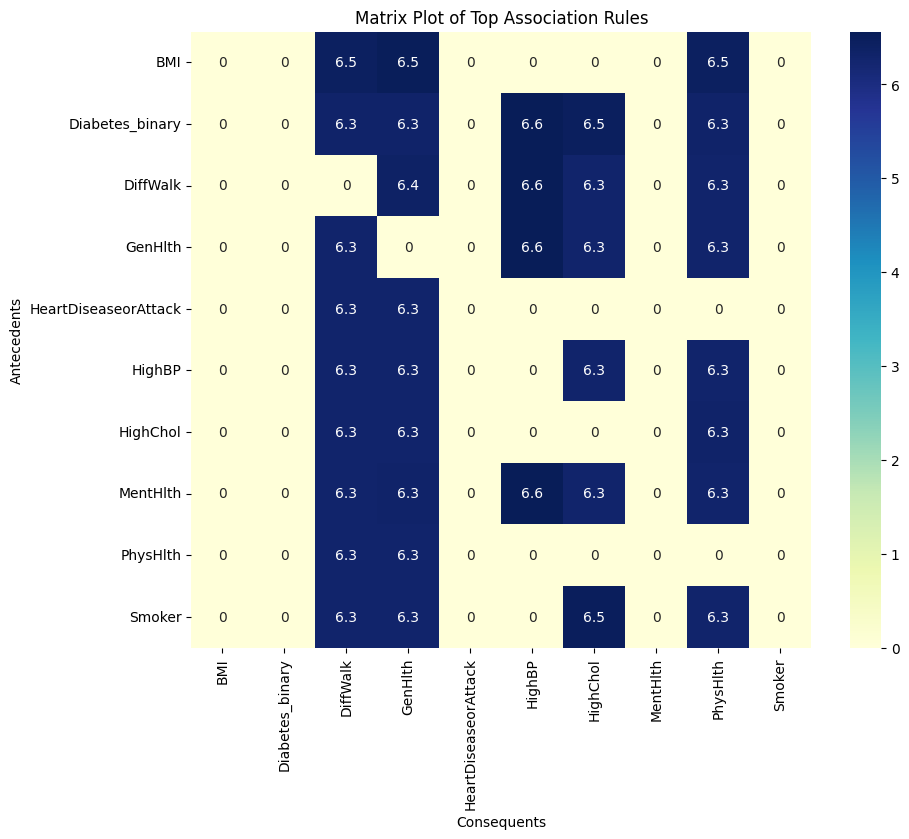

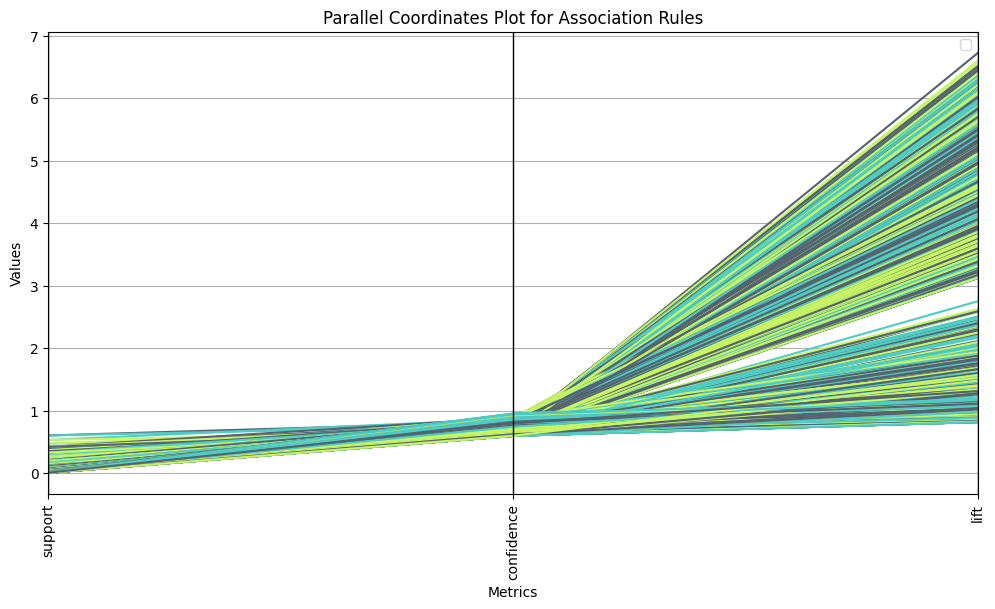

In [66]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

# Assuming 'health_binarized' is your preprocessed dataset

# Step 1: Apply Apriori to find frequent itemsets of length 2
frequent_itemsets_apriori = apriori(health_binarized, min_support=0.01, use_colnames=True, max_len=2)

# Step 2: Filter the dataset to include only frequent itemsets found by Apriori
# This step depends on your specific dataset and may involve complex filtering logic

# Step 3: Apply FP-Growth on the filtered dataset to find longer frequent itemsets
frequent_itemsets_fpgrowth = fpgrowth(health_binarized, min_support=0.01, use_colnames=True)

# Combine the results from both algorithms
combined_frequent_itemsets = pd.concat([frequent_itemsets_apriori, frequent_itemsets_fpgrowth]).drop_duplicates().reset_index(drop=True)

# Generate association rules from the combined frequent itemsets
rules = association_rules(combined_frequent_itemsets, metric="confidence", min_threshold=0.6)

# Filter and sort rules
filtered_rules = rules[(rules['lift'] > 1) & (rules['confidence'] > 0.7)]
sorted_rules = filtered_rules.sort_values(by='lift', ascending=False)

# Display top 10 rules
print(sorted_rules.head(10))

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'rules' is your DataFrame containing the association rules
plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', size='lift', data=rules, legend=False, sizes=(20, 200))
plt.title('Support vs. Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

import networkx as nx

def draw_graph(rules, top_n):
    G = nx.DiGraph()

    top_rules = rules.nlargest(top_n, 'lift')
    for _, rule in top_rules.iterrows():
        for antecedent in rule['antecedents']:
            for consequent in rule['consequents']:
                G.add_edge(antecedent, consequent, weight=rule['lift'])

    pos = nx.spring_layout(G, k=1.5, iterations=50)
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', edge_color=range(len(G.edges)), edge_cmap=plt.cm.Blues, width=2.0)
    plt.title('Network Graph of Top Association Rules')
    plt.show()

# Draw network graph for top 20 rules
draw_graph(rules, top_n=20)

import numpy as np

# Create a matrix for the top 20 rules
top_rules = rules.nlargest(20, 'lift')
itemset = sorted(set(item for sublist in top_rules['antecedents'].tolist() + top_rules['consequents'].tolist() for item in sublist))
matrix = np.zeros((len(itemset), len(itemset)))

item_index = {item: idx for idx, item in enumerate(itemset)}

for _, rule in top_rules.iterrows():
    for antecedent in rule['antecedents']:
        for consequent in rule['consequents']:
            matrix[item_index[antecedent], item_index[consequent]] = rule['lift']

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, xticklabels=itemset, yticklabels=itemset, cmap='YlGnBu')
plt.title('Matrix Plot of Top Association Rules')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.show()

from pandas.plotting import parallel_coordinates

# Prepare data for parallel coordinates plot
parallel_data = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].copy()
parallel_data['antecedents'] = parallel_data['antecedents'].apply(lambda x: ', '.join(list(x)))
parallel_data['consequents'] = parallel_data['consequents'].apply(lambda x: ', '.join(list(x)))
parallel_data['rule'] = parallel_data['antecedents'] + ' -> ' + parallel_data['consequents']

# Plot
plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_data, 'rule', cols=['support', 'confidence', 'lift'], color=('#556270', '#4ECDC4', '#C7F464'))
plt.title('Parallel Coordinates Plot for Association Rules')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.legend([])
plt.xticks(rotation=90)
plt.show()


#from PyARMViz import PyARMViz

# Assuming 'rules' is your DataFrame containing the association rules
#viz = PyARMViz(rules)
#viz.plot()
